In [4]:
from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
policys = ["tpa(10000)"]
run_log_drs = [
    "/mnt/network_drive/lrq/logs/logs_2025-08-09-12-04-15/run_0",
]
report_map = {}
for i, run_log_dir in enumerate(run_log_drs):
    req_counter_metric = f"router:req_counter"
    rps_counter_metric = f"router:rps_counter"
    tok_counter_metric = f"router:tok_counter"
    ins_counter_metric = f"router:ins_counter"
    ins_needed_metric = f"router:ins_needed"
    metrics_list = [req_counter_metric, ins_counter_metric, ins_needed_metric, tok_counter_metric, rps_counter_metric]
    report_file_path = analyze_data(run_log_dir, metrics_list)
    with open(report_file_path, 'r') as f:
        report = json.load(f)


    report_map[policys[i]] = report

Starting Prometheus...


ts=2025-08-09T04:17:47.078Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-08-09T04:17:47.078Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-08-09T04:17:47.078Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-08-09T04:17:47.078Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 7130c92067c2 (none))"
ts=2025-08-09T04:17:47.078Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-08-09T04:17:47.078Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-08-09T04:17:47.085Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:req_counter', 'router:ins_counter', 'router:ins_needed', 'router:tok_counter', 'router:rps_counter']
params_list: [{'query': 'router:req_counter', 'start': '2025-08-09T04:06:26Z', 'end': '2025-08-09T06:06:26Z', 'step': '1s'}, {'query': 'router:ins_counter', 'start': '2025-08-09T04:06:26Z', 'end': '2025-08-09T06:06:26Z', 'step': '1s'}, {'query': 'router:ins_needed', 'start': '2025-08-09T04:06:26Z', 'end': '2025-08-09T06:06:26Z', 'step': '1s'}, {'query': 'router:tok_counter', 'start': '2025-08-09T04:06:26Z', 'end': '2025-08-09T06:06:26Z', 'step': '1s'}, {'query': 'router:rps_counter', 'start': '2025-08-09T04:06:26Z', 'end': '2025-08-09T06:06:26Z', 'step': '1s'}]


In [5]:

def identify_spikes(timestamps, values, threshold=2):
    """
    Identify spikes in the curve based on the threshold.

    A spike is defined as a point where the next value is more than
    `threshold` greater than the current value, and the current value is not zero.

    Args:
        timestamps (list of float): List of timestamp values.
        values (list of float): Corresponding list of values.
        threshold (float): The minimum increase to consider as a spike.

    Returns:
        list of float: List of timestamps where spikes occur.
    """
    if len(timestamps) != len(values):
        raise ValueError("Timestamps and values must have the same length.")

    spikes = []
    for i in range(len(values) - 1):
        if values[i] != 0 and values[i + 1] / values[i] >= threshold:
            spikes.append(timestamps[i])

    return spikes

In [6]:
def get_curves(report, model_name, metrics_names):
    start_str = report.get('router_start_time', 'N/A')
    end_str = report.get('router_end_time', 'N/A')
    tz_sg = ZoneInfo("Asia/Singapore")
    router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
    router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()

    router_metrics = report['prom_data'].get("router", {})
    model_metrics = router_metrics.get(model_name, {})
    results = {}
    for metric_name in metrics_names:
        metrics = model_metrics[metric_name] 
        values = [float(t[1]) for t in metrics if float(t[0]) <= router_end_time]
        timestamps = [float(t[0]) for t in metrics if float(t[0]) <= router_end_time]
        timestamp_offsets = [t - router_start_time for t in timestamps]
        results[metric_name] = (timestamp_offsets, values)
    return results

----Under policy tpa(10000)----
Traffic spikes: [118.78475499153137, 178.78475499153137]
Needed instance spikes: [119.28475499153137, 178.78475499153137]
Actual instance spikes: [123.78475499153137, 184.78475499153137]
Over 2 identified spikes, avg reaction latency: 0.50s, avg cold start latency: 4.50s


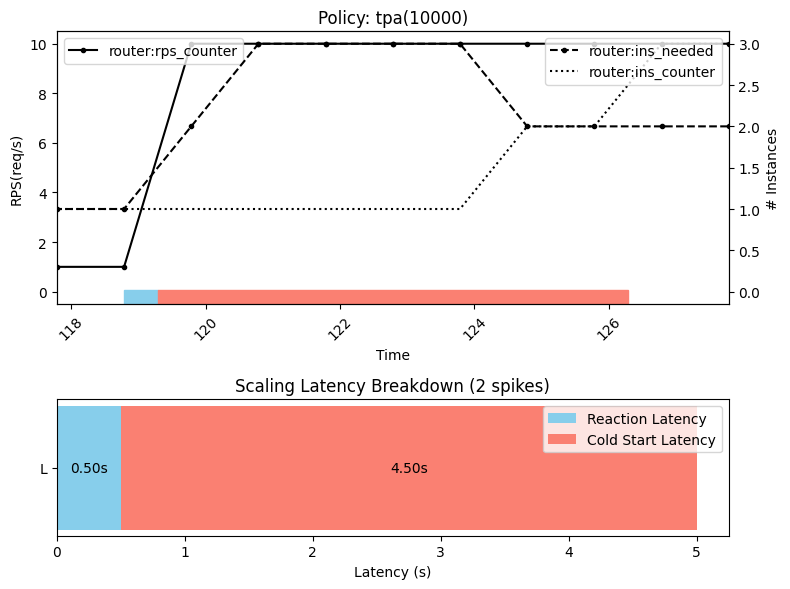

In [8]:
import matplotlib.pyplot as plt

traffic_metric_name = "router:rps_counter"
ins_needed_metric = "router:ins_needed"
ins_counter_metric = "router:ins_counter"
model_name = "meta-llama/Llama-3.1-8B"
for policy_name in policys:

    metric_names = [traffic_metric_name, ins_needed_metric, ins_counter_metric]

    curves = get_curves(
        report_map[policy_name], model_name, metric_names
    )
    fig, (ax1, ax2) = plt.subplots(
        2, 1,               # 2 rows, 1 column
        figsize=(8, 6),     # Size of the entire figure
        gridspec_kw={'height_ratios': [2, 1]}  # ax1 is 2x as tall as ax2
    )
    ax1_2 = ax1.twinx()
    traffic_curve = curves[traffic_metric_name]
    ins_needed_curve = curves[ins_needed_metric]
    ins_counter_curve = curves[ins_counter_metric]
    ax1.plot(traffic_curve[0], traffic_curve[1], label=traffic_metric_name, linestyle='-', color='black', marker='.')
    ax1_2.plot(ins_needed_curve[0], ins_needed_curve[1], label=ins_needed_metric, linestyle='--', color='black',marker='.')
    ax1_2.plot(ins_counter_curve[0], ins_counter_curve[1], label=ins_counter_metric, linestyle=':', color='black')

        
    ax1.set_title(f"Policy: {policy_name}")
    ax1.set_xlabel("Time")
    ax1.tick_params(axis='x', rotation=45)
    # ax1.set_ylim([0.9,11])
    ax1.legend(loc='upper left')
    ax1.set_ylabel("RPS(req/s)")
    ax1_2.legend(loc='upper right')
    ax1_2.set_ylabel("# Instances")
    # ax1_2.set_ylim([0.9,2.1])
    traffic_spikes = identify_spikes(traffic_curve[0], traffic_curve[1])
    # traffic_spikes = [traffic_spikes[0], traffic_spikes[3]]
    ins_needed_spikes = identify_spikes(ins_needed_curve[0], ins_needed_curve[1])
    ins_needed_spikes[0] += 0.5
    ins_counter_spikes = identify_spikes(ins_counter_curve[0], ins_counter_curve[1])
    # ins_needed_spikes = ins_needed_spikes[:2]
    print(f"----Under policy {policy_name}----")
    print(f"Traffic spikes: {traffic_spikes}")
    print(f"Needed instance spikes: {ins_needed_spikes}")
    print(f"Actual instance spikes: {ins_counter_spikes}")
    assert len(traffic_spikes) == len(ins_needed_spikes) == len(ins_counter_spikes)
    reaction_latencys = []
    coldstart_latencys = []
    for i in range(len(traffic_spikes)):
        traffic_spike = traffic_spikes[i]
        ins_needed_spike = ins_needed_spikes[i]
        ins_counter_spike = ins_counter_spikes[i]
        reaction_latency = ins_needed_spike - traffic_spike
        coldstart_latency = ins_counter_spike - ins_needed_spike
        reaction_latencys.append(reaction_latency)
        coldstart_latencys.append(coldstart_latency)

    # avg_reaction_latency = sum(reaction_latencys) / len(reaction_latencys)
    # avg_coldstart_latency = sum(coldstart_latencys) / len(coldstart_latencys)
    avg_reaction_latency = reaction_latencys[0]
    avg_coldstart_latency = coldstart_latencys[0]
    print(f"Over {len(traffic_spikes)} identified spikes, avg reaction latency: {avg_reaction_latency:.2f}s, avg cold start latency: {avg_coldstart_latency:.2f}s")
    # Create horizontal stacked bar
    labels = ['L']
    reaction = avg_reaction_latency
    coldstart = avg_coldstart_latency

    ax2.barh(labels, reaction, color='skyblue', label='Reaction Latency')
    ax2.barh(labels, coldstart, left=reaction, color='salmon', label='Cold Start Latency')

    # Annotate values
    ax2.text(reaction / 2, 0, f'{reaction:.2f}s', va='center', ha='center', color='black')
    ax2.text(reaction + coldstart / 2, 0, f'{coldstart:.2f}s', va='center', ha='center', color='black')

    # Labels and legend
    ax2.set_xlabel('Latency (s)')
    ax2.set_title(f'Scaling Latency Breakdown ({len(traffic_spikes)} spikes)')
    ax2.legend()


    reaction_start = traffic_spikes[0]
    cold_start_start = ins_needed_spikes[0]
    cold_start_end = ins_needed_spikes[0] + 7

    ax1.set_xlim([traffic_spikes[0] - 1, traffic_spikes[0]+9])
    ax1.axvspan(reaction_start, cold_start_start, ymin=0, ymax=0.05, color='skyblue', label='Reaction Latency')

    # Add cold start latency (salmon)
    ax1.axvspan(cold_start_start, cold_start_end, ymin=0, ymax=0.05, color='salmon', label='Cold Start Latency')
    plt.tight_layout()
    plt.show()